In [ ]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from oilproblem.reducing_dimension import delete_constant, variance_filter, corr_y, feature_selection
from oilproblem.aws.oil_config import static_confs
from oilproblem.fit import metrics, plot_fit_metrics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Fit the linear regression using GridSearchCV

### definitions

In [2]:
NPERIODS = 3
_plot = False
conf = static_confs()
label = 'BP'
_rep_dir = ''

### prepare the dataset

In [6]:
df = pd.read_csv('data_prep.csv')
df = df.set_index(pd.to_datetime(df["raw_date"], format='%Y-%m-%d'))
del df['raw_date']
y = df[label]

### preprocess

In [7]:
df, rep = delete_constant(df, _plot=_plot)
df, rep = variance_filter(df, 0.5, label, plot=_plot, _path=None)
df, rep = corr_y(df, y, _strong=0.9, _plot=_plot, _path=_rep_dir)
df, rep, _ = feature_selection(df, y, _k=20, _plot=_plot, _path=_rep_dir, conf=conf)
df.to_csv('dada.csv')
X = df.as_matrix()

# MODELS

### linear regression

In [82]:
model = sklearn.linear_model.LinearRegression()
parameters = {'fit_intercept': [True, False], 'normalize': [True, False], 'copy_X': [True, False]}

### Ridge

In [13]:
model_f = sklearn.linear_model.Ridge
model = model_f()
parameters = {'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
              'normalize': [True, False], 
              'tol': [10e-02, 10e-03, 10e-04, 10e-05, 10e-06], 
              'fit_intercept': [True,False]}

### Lasso

In [14]:
model_f = sklearn.linear_model.Lasso
model = model_f()
parameters = {'alpha':[0, 0.001, 0.1, 0.5, 1, 10],
              'normalize': [True, False], 
              'tol': [10e-02, 10e-03, 10e-04, 10e-05, 10e-06], 
              'fit_intercept': [True,False]}

### custom score

In [83]:
from sklearn.metrics import make_scorer, r2_score
r2_moje = make_scorer(r2_score, greater_is_better = True)

### fit

In [84]:
from sklearn.metrics import r2_score
grid = GridSearchCV(model, parameters, cv=None, scoring = r2_moje)
grid.fit(X, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'fit_intercept': [True, False], 'normalize': [True, False], 'copy_X': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(r2_score), verbose=0)

### grid

In [85]:
res = pd.DataFrame(grid.cv_results_['params'])
sel = list(grid.cv_results_['params'][0].keys())+['mean_test_score',
       'std_test_score', 'rank_test_score', 'mean_train_score',
       'std_train_score','r2']
for key in sel:
    try:
        res[key] = grid.cv_results_[key] 
    except:
        pass

### r^2

In [86]:
r2 = list()
_dict = dict()
for par in grid.cv_results_['params']:
    _m = model_f(**par)
    _m.fit(X,y)
    _dict['forecasted_y'] = list(np.insert(_m.predict(X[-NPERIODS:]), 0, [y[-(NPERIODS+1)]], axis=0))
    _dict = metrics(y, _m.predict(X), _dict)
    r2.append(round(_dict['r2'],2))
res['r2']=r2
res[sel].sort_values('rank_test_score', ascending = True).head(10)

,copy_X,fit_intercept,normalize,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score,r2
2,True,False,True,-3.856084,2.619494,1,0.748477,0.043951,0.57
3,True,False,False,-3.856084,2.619494,1,0.748477,0.043951,0.57
6,False,False,True,-3.856084,2.619494,1,0.748477,0.043951,-62.29
7,False,False,False,-3.856084,2.619494,1,0.748477,0.043951,-62.29
1,True,True,False,-49.338649,34.254753,5,0.855964,0.017343,0.66
0,True,True,True,-49.338649,34.254753,6,0.855964,0.017343,0.00
4,False,True,True,-49.338649,34.254753,6,-14.154538,12.745915,0.00
5,False,True,False,-49.338649,34.254753,6,-13.218899,12.700662,0.00


# results

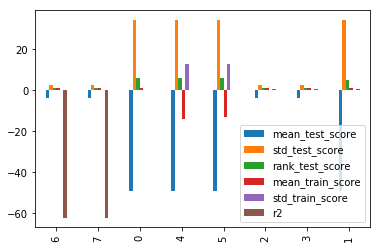

In [87]:
res.sort_values('r2').plot(kind='bar')
plt.show()

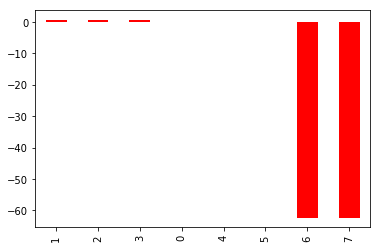

In [88]:
res.sort_values('r2', ascending = False).head()
res.sort_values('r2', ascending = False).r2.head(50).plot(kind = 'bar', color = 'red')
plt.show()

### fit metrics

In [89]:
grid.best_params_

{'copy_X': True, 'fit_intercept': False, 'normalize': True}

In [90]:
best = model_f(**grid.best_params_)
best.fit(X,y)

Lasso(alpha=1.0, copy_X=True, fit_intercept=False, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [91]:
_fit_report = dict()
_fit_report['model'] = str(model).split("(")[0]
_fit_report['label'] = 'BP'
_fit_report['forecasted_y'] = list(np.insert(best.predict(X[-NPERIODS:]), 0, [y[-(NPERIODS+1)]], axis=0))
_fit_report = metrics(y, best.predict(X), _fit_report)
_fit_report['actual_y'] = list(y[-(NPERIODS+1):])
fit_metrics = _fit_report
y_pred = np.array(fit_metrics['y_pred'])

### prob plot

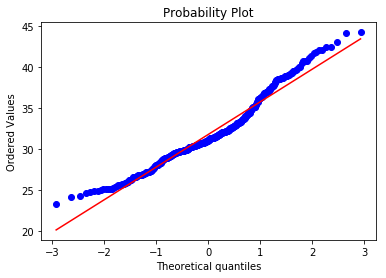

In [92]:
stats.probplot(fit_metrics['y_true'] - np.array(fit_metrics['y_pred']), dist="norm", plot=plt)
plt.show()

### residuals

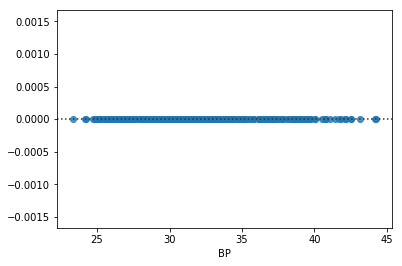

In [93]:
sns.residplot(y, y_pred)
plt.show()

### regplot

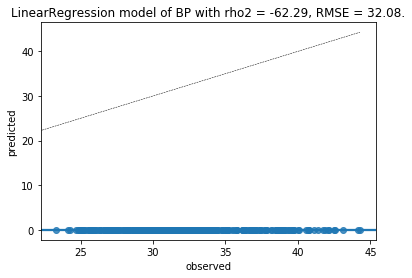

In [94]:
ax = plt.subplot(111)
sns.regplot(y, y_pred)
fig = ax.get_figure()

lims = [min(min(y), min(y_pred)),  # min of both axes
    max(max(y), max(y_pred))]  # max of both axes

plt.xlabel('observed')
plt.ylabel('predicted')
plt.plot(lims,lims, "--", color = 'black', linewidth = 0.5)

plt.title(fit_metrics['model']+" model of {} with rho2 = {:.2f}, RMSE = {:.2f}.".format(
    fit_metrics['label'][:20], fit_metrics['r2'],fit_metrics['rmse']))
plt.show()

### temporal

In [96]:
plt.plot(y, 'ro')
plt.plot(y_pred, c="black", lw=2)
plt.show()

ValueError: ordinal must be >= 1

### forecast

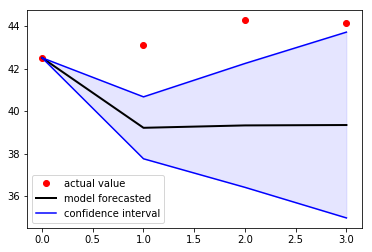

In [265]:
plt.plot(fit_metrics['actual_y'], 'ro', label = 'actual value')
plt.plot(fit_metrics['forecasted_y'], c="black", lw=2, label = 'model forecasted')
plt.fill_between(list(range(NPERIODS+1)), fit_metrics['ci_low'], fit_metrics['ci_high'], color = 'blue', alpha = 0.1)
plt.plot(fit_metrics['ci_low'], c='blue', label= 'confidence interval')
plt.plot(fit_metrics['ci_high'], c='blue')
plt.legend()
plt.show()